
# Entornos de soporte al desarrollo de simulaciones: Simpy - Parte 1

## 1. Instalación de Simpy
Existen diversas alternativas para instalar **simpy** (no confundir con _sympy_), sin embargo, en esta subsección mostraremos cómo hacerlo.


### 1.1. Pasos a seguir:
En virtud de que **simpy** requiere la versión 3.7 de Python, llevaremos a cabo el proceso para instalar dicha versión:
1. Creamos el entorno virtual llamado "simulacion" con la versión 3.7 de Python:

        conda activate
        
2. Installamos **simpy**  en el entorno creado:
        pip3 install -U simpy
        


Si la instalación ha sido exitosa, podremos ejecutar el siguiente código sin inconvenientes:

In [6]:
import simpy

# Definimos un reloj:
def reloj(env, nombre, tiempo):
    while True:
        print(nombre,">",env.now) 
        yield env.timeout(tiempo) # Pasamos el control al programa principal
        
env=simpy.Environment() # Creamos un entorno de simulación
env.process(reloj(env, 'R. Rapido',0.25)) # Ejecutamos un "reloj" rapido (timer) en el entorno con el tiempo especificado
env.process(reloj(env, 'R. Lento',0.5)) # Ejecutamos un "reloj" lento (timer) en el entorno con el tiempo especificado

env.run(until=2.1) # Ejecutamos los procesos 2 unidades de tiempo

R. Rapido > 0
R. Lento > 0
R. Rapido > 0.25
R. Lento > 0.5
R. Rapido > 0.5
R. Rapido > 0.75
R. Lento > 1.0
R. Rapido > 1.0
R. Rapido > 1.25
R. Lento > 1.5
R. Rapido > 1.5
R. Rapido > 1.75
R. Lento > 2.0
R. Rapido > 2.0


## 2. Ejemplo del negocio de lavado de autos [5]

Este ejemplo permite simular un negocio de lavado de automóviles. De igual forma, es importante destacar que este ejemplo aborda los siguientes puntos:

* Estados de espera por otros procesos
* Recursos: clase **Resource**


### 2.1. Características del sistema real a simular

Es importante observar que el negocio de lavado de autos tiene características propias a su naturaleza. A continuación establecemos dichas peculiaridades a tener en mente en el momento de llevar a cabo la simulación:

* El negocio tiene un número limitado de máquinas de lavado.
* Se puede recibir un cierto número de vehículos para ser lavados, de los cuáles los que no estén siendo procesados tendrán que esperar.
* Una vez que un vehículo entra a la máquina, debe ser lavado y solo al finalizar la limpieza podrá salir de la misma, dejando un espacio libre a otro vehículo.

### 2.2. Desarrollo de la simulación

A continuación procedemos a desarrollar la simulación.

Como primer paso, importamos las librerías necesarias y establecemos los parámetros requeridos:
* Variables de interés
* Tiempo de simulación
* Parámetros de inicialización (número de máquinas, tiempo de lavado, intervalo de llegada de vehículos).

In [7]:
import simpy
import random

# Maximo de vehiculos que puede recibir el negocio
MAX_VEHICULOS = 57
# Total de maquinas de lavado con que cuenta el negocio
NUM_MAQUINAS = 3
# Tiempo que tarda en lavarse un vehiculo (minutos)
TIEMPO_LAVADO = 7
# Intervalo de tiempo en que llegan vehiculos (minutos)
INTERVALO_LLEGADA = 9
# Tiempo de simulación
TIEMPO_SIMULACION = 23

class Lavanderia(object):
    
    def __init__(self, environment, num_maquinas, tiempo_lavado):
        # Guardamos como variable el entorno de ejecucion
        self.env=environment
        # Creamos el recurso que representa las maquinas
        self.maquinas = simpy.Resource(environment, num_maquinas)
        # Variable para el tiempo de lavado
        self.tiempo_lavado = tiempo_lavado
        
    def lavar_vehiculo(self, vehiculo):
        # Este metodo representa el proceso de lavado del vehículo.
        # Se ingresa el vehículo y se lava
        
        # Simulamos el tiempo que tarda en lavarse el vehiculo
        # Es importante notar que la instruccion "yield" es distinta de "sleep"
        # ya que esta ultima bloquea el hilo de ejecucion durante 't' unidades de tiempo,
        # mientras que 'yield' no bloquea el hilo de ejecucion, solo lo suspende mientras
        # el evento de 'lavado' se realice
        yield self.env.timeout(TIEMPO_LAVADO)
        
        # Simulamos que se ha limpiado parte (%) de la suciedad del vehiculo
        # Para el % generamos un entero entre 30 y 90
        print('Removido  {%d%%} suciedad vehiculo => %s ' \
              % (random.randint(30,90), vehiculo))
        
    
def llegada_vehiculo(env, nombre, lavanderia):
    # Usamos el reloj de la simulacion (env.now()) para indicar a la
    # hora que llega el vehiculo con el nombre pasado como parametro
    print('Llega vehiculo: %s a la hora %.2f.' % (nombre, env.now))
    
    # Especificamos que vamos a usar un recurso (Resource) que representa
    # la maquina de lavado
    with lavanderia.maquinas.request() as maquina:
        # Ocupamos la maquina de lavado
        yield maquina
        # Indicamos que vehiculo entra a la lavanderia
        print('Entra vehiculo a lavarse: %s a la hora %.2f.' % (nombre, env.now))
        # Procesamos la operacion de lavado
        yield env.process(lavanderia.lavar_vehiculo(nombre))
        # Una vez que termina la llamada con 'yield', se indica que se ha lavado el vehiculo
        print('Vehiculo [%s] lavado a las %.2f.' % (nombre, env.now))
    
    
def ejecutar_simulacion(env, num_maquinas, tiempo_lavado, intervalo):
    lavanderia=Lavanderia(env, num_maquinas, tiempo_lavado)
    # Creamos 5 llegadas de vehiculos iniciales
    for i in range(5):
        env.process(llegada_vehiculo(env, 'Vehiculo-%d'%(i+1),lavanderia))
    
    # Ejecutamos la simulacion
    while True:
        yield env.timeout(random.randint(intervalo-2, intervalo+2)) # Generar un randomico de 7 - 11 
        i+=1
        # Mientras se lavan los vehiculos generamos mas vehiculos
        env.process(llegada_vehiculo(env,'Vehiculo-%d'%(i+1),lavanderia))

print('Lavanderia UPS')

# Creamos el entorno de simulacion
env=simpy.Environment()
env.process(ejecutar_simulacion(env, NUM_MAQUINAS, TIEMPO_LAVADO, INTERVALO_LLEGADA))

# Ejecutamos el proceso durante el tiempo de simulacion
env.run(until = TIEMPO_SIMULACION)


Lavanderia UPS
Llega vehiculo: Vehiculo-1 a la hora 0.00.
Llega vehiculo: Vehiculo-2 a la hora 0.00.
Llega vehiculo: Vehiculo-3 a la hora 0.00.
Llega vehiculo: Vehiculo-4 a la hora 0.00.
Llega vehiculo: Vehiculo-5 a la hora 0.00.
Entra vehiculo a lavarse: Vehiculo-1 a la hora 0.00.
Entra vehiculo a lavarse: Vehiculo-2 a la hora 0.00.
Entra vehiculo a lavarse: Vehiculo-3 a la hora 0.00.
Removido  {64%} suciedad vehiculo => Vehiculo-1 
Removido  {35%} suciedad vehiculo => Vehiculo-2 
Removido  {70%} suciedad vehiculo => Vehiculo-3 
Vehiculo [Vehiculo-1] lavado a las 7.00.
Vehiculo [Vehiculo-2] lavado a las 7.00.
Vehiculo [Vehiculo-3] lavado a las 7.00.
Entra vehiculo a lavarse: Vehiculo-4 a la hora 7.00.
Entra vehiculo a lavarse: Vehiculo-5 a la hora 7.00.
Llega vehiculo: Vehiculo-6 a la hora 11.00.
Entra vehiculo a lavarse: Vehiculo-6 a la hora 11.00.
Removido  {46%} suciedad vehiculo => Vehiculo-4 
Removido  {83%} suciedad vehiculo => Vehiculo-5 
Vehiculo [Vehiculo-4] lavado a las 14.0

## Práctica  - SimPy 

## - Investigar el proceso de atencion de un paciente diagnosticado con COVID-19, ademas de tiempos de atencion, recursos necesarios y tipos de pacientes.

Los pacientes con enfermedad leve pueden presentarse en servicios de urgencias, consultas externas o centros de atención primaria, o ser detectados durante actividades de telemedicina o de extensión comunitaria, como las visitas a domicilio

Para contener la transmisión del virus, recomendamos que los casos sospechosos o confirmados de COVID-19 leve se aíslen de acuerdo con la ruta asistencial establecida para la COVID-19. El aislamiento puede hacerse en un centro sanitario designado para la COVID-19, en un centro comunitario o en el domicilio del paciente (autoaislamiento).

Recomendamos que los pacientes con COVID-19 leve reciban tratamiento sintomático, como antipiréticos analgésicos, y nutrición y rehidratación adecuadas

Se informará a los pacientes con COVID-19 leve sobre los signos y síntomas de complicaciones que deben llevarlos a buscar atención urgente.

Recomendamos una estrecha observación de los pacientes con COVID-19 moderada para detectar signos o síntomas de progresión de la enfermedad. Debe haber mecanismos para un seguimiento estrecho en caso de que se necesite intensificar la atención médica.

Todas las áreas en las que se puedan atender pacientes graves deben estar equipadas con pulsioxímetros, sistemas de administración de oxígeno en funcionamiento e interfaces desechables, de un solo uso, para administrar oxígeno (cánulas nasales, máscaras de Venturi y máscaras con bolsa reservorio).

Recomendamos la administración inmediata de oxigenoterapia suplementaria a todo paciente con signos de emergencia o sin signos de emergencia pero con SpO2 < 90%.

Los pacientes serán observados de cerca para detectar signos de deterioro clínico, como la insuficiencia respiratoria de progresión rápida y el choque, y responder inmediatamente con intervenciones de apoyo.

Los líquidos se administrarán con cautela a pacientes con COVID-19 sin hipoperfusión tisular y respuesta a los líquidos.

## - Investigar en cada una de las provincias asignadas el numero de hospitales, camas, respiradores y personal medico, limpieza y enfermeria.

Brasil, el país más grande de América Latina, está cada vez más cerca del colapso de su sistema sanitario por cuenta de las 25.598 muertes y los 411.821 infectados que deja la pandemia hasta este 27 de mayo. 

La investigación se centra, por el momento, en la revisión de un contrato por valor de 835 millones de reales (unos 143 millones de dólares) para construir y administrar siete hospitales de campaña con 1.400 camas en el Estado Río de Janeiro, el segundo más afectado por el brote en Brasil, con 4.361 muertos y más de 40.000 contagiados. Según la Fiscalía, hay numerosas irregularidades, “pruebas robustas de fraudes” e indicios de la participación directa del gobernador y su esposa. 

Además, hay que mencionar que en este país tropical el 66% de los pacientes entubados pierde la vida, frente al 42% del Reino Unido y al 44% de Países Bajos. Esta información se basa en un estudio de la Asociación de Medicina Intensiva Brasileña, que evaluó -entre el 1 de marzo y el 15 de mayo- 450 hospitales en todo Brasil y 13.600 camas de terapia intensiva. 

Las "ofertas especiales" en los centros privados

La red privada de hospitales tampoco contribuye a aliviar esta difícil situación. En la nación solo un tercio de la población puede costear los carísimos seguros médicos, cuyo precio aumenta cada año muy por encima de la tasa de inflación y sin que el gobierno ejerza ningún tipo de control. En Río de Janeiro, algunos hospitales están comercializando el ‘paquete Covid-19’. La "oferta especial" incluye seis horas en Urgencias, análisis de sangre, tomografía y rayos X por el pago de 5.000 reales (unos 860 dólares). 

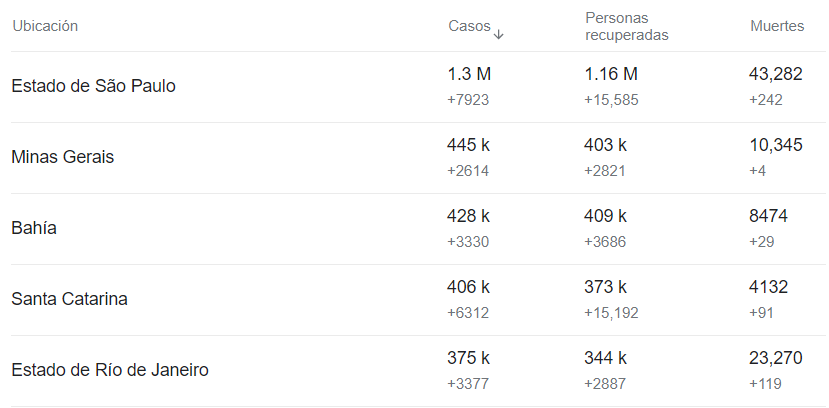

Brasil: 31.790 profesionales de la salud están contagiados con coronavirus

Según Macário, del total de casos sospechosos, los más afectados son los técnicos o asistentes de enfermería (34,2%). Después están las enfermeras (16,9%), médicos (13,3%) y recepcionistas (4,3%).

## - Finalmente el costo de atender a un paciente con COVID-19 y medicamentos.

Gilead Sciences Inc fijó el lunes el precio de su antiviral para el COVID-19, el remdesivir, en 2340 dólares por paciente para los países más ricos y acordó enviar casi todo su suministro a Estados Unidos durante los próximos tres meses.

El precio está ligeramente por debajo del rango de 2520 a 2800 dólares sugerido la semana pasada por el grupo de investigación de precios de medicamentos de Estados Unidos, el Instituto para la Revisión Clínica y Económica (ICER), después de que investigadores británicos dijeron que encontraron que la dexametasona, un esteroide barato, redujo significativamente la mortalidad entre los pacientes gravemente enfermos de COVID-19.


## Referencias

[1] Matloff, N. (2008). Introduction to Discrete-Event Simulation and the SimPy Language.

[2] Team Simpy (2017). SimPy Documentation, Release 3.0.10, 2017. 

URL: https://media.readthedocs.org/pdf/simpy/latest/simpy.pdf 

https://www.aa.com.tr/es/mundo/brasil-31790-profesionales-de-la-salud-están-contagiados-con-coronavirus/1841456
   
https://apps.who.int/iris/bitstream/handle/10665/332638/WHO-2019-nCoV-clinical-2020.5-spa.pdf

https://www.eluniverso.com/noticias/2020/06/29/nota/7889298/fijan-2300-dolares-paciente-precio-remdesivir-contra-coronavirus